# Notebook Processo Seletivo Aluno Especial IA-024 1S2024 FEEC-UNICAMP
versão 5 de fevereiro de 2024, 19h

In [1]:
!pip install torchtext
!pip install 'portalocker>=2.0.0'

ERROR: Invalid requirement: "'portalocker"


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import IMDB
from collections import Counter
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.data import get_tokenizer

In [3]:
# Parâmetros gerais de execução do Notebook
# Uso do Tokenizador
use_tokenizer = True

# Preloading data
preload_to_gpu = True

# Learning Rate
best_LR = 0.1

# Shuffle Dataloader (treinamento)
train_shuffle = True

# Número de amostras usadas
n_samples = 25000

# Balanceamento do dataset
balance_dataset = False


## I - Vocabulário e Tokenização

In [4]:
# limit the vocabulary size to 20000 most frequent tokens
vocab_size = 20000

# I.1. Na célula de calcular o vocabulário, aproveite o laço sobre IMDB de treinamento e utilize um segundo contador
# para calcular o número de amostras positivas e amostras negativas.
# Calcule também o comprimento médio do texto em número de palavras dos textos das amostras.

counter = Counter()
counter_lbl = Counter({"pos": 0, "neg": 0, "total": 0})
total_review_len = 0
avg_review_len = 0

for (label, line) in list(IMDB(split='train'))[:n_samples]:
    if (use_tokenizer):
      tokenizer = get_tokenizer('basic_english')
      # tokenize the sentence
      line = tokenizer(line)
      counter.update(line)
    else:
      counter.update(line.split())

    # Número de amostras positivas e negativas
    if (label == 1):
      counter_lbl['neg'] += 1
    else:
      counter_lbl['pos'] += 1
    counter_lbl['total'] += 1

    if (use_tokenizer):
      total_review_len += len(line)
    else:
      total_review_len += len(line.split())

# Comprimento médio
avg_review_len = total_review_len / counter_lbl['total']

# I.2 Mostre as cinco palavras mais frequentes do vocabulário e as cinco palavras menos frequentes.
# Qual é o código do token que está sendo utilizado quando a palavra não está no vocabulário?
# Calcule quantos tokens das frases do conjunto de treinamento que não estão no vocabulário.

# create a vocabulary of the 20000 most frequent tokens
most_frequent_words = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
vocab = {word: i for i, word in enumerate(most_frequent_words, 1)} # words indexed from 1 to 20000
vocab_size = len(vocab) #Errata

print("Amostras positivas, negativas e totais:")
print(counter_lbl)
print()

print("Comprimento médio do texto em palavras")
print(avg_review_len)
print()

print("Cinco palavras mais frequentes:")
print(most_frequent_words[:5])
print()

print("Cinco palavras menos frequentes:")
print(most_frequent_words[-5:])
print()

Amostras positivas, negativas e totais:
Counter({'total': 25000, 'pos': 12500, 'neg': 12500})

Comprimento médio do texto em palavras
270.68748

Cinco palavras mais frequentes:
['the', '.', ',', 'and', 'a']

Cinco palavras menos frequentes:
['voicing', 'hazard', 'lynda', 'gft', 'watergate']



In [5]:
# I.2 Calcule quantos tokens das frases do conjunto de treinamento que não estão no vocabulário.

def encode_sentence(sentence, vocab, use_tokenizer):
    if (use_tokenizer):
       sentence = tokenizer(sentence)
       return [vocab.get(word, 0) for word in sentence]
    else:
      return [vocab.get(word, 0) for word in sentence.split()] # 0 for OOV

encode_sentence("I like Pizza", vocab, use_tokenizer)

# Cálculo do número de tokens que não estão no vocabulário na base de treinamento:
tokens = []
for (label, line) in list(IMDB(split='train'))[:n_samples]:
  tokens.extend(encode_sentence(line, vocab, use_tokenizer))

print("Número de tokens que não estão no vocabulário na base de treinamento:")
print(tokens.count(0))

Número de tokens que não estão no vocabulário na base de treinamento:
174226


In [6]:
# Função para selecionar dados balanceados
from random import shuffle

def balanced_dataset(data, samples):
  if (balance_dataset):
    data_pos = [(label,line) for label, line in data if label == 2][:int(samples/2)]
    data_neg = [(label,line) for label, line in data if label == 1][:int(samples/2)]
    
    data_bal = data_pos + data_neg
    shuffle(data_bal)

    return data_bal
  else:
     data = [(label,line) for label, line in data][:samples]
     return data

# Aplicando sobre a base de treinamento

train_data = IMDB(split='train')
counter = Counter()
total_review_len = 0
avg_review_len = 0

for (label, line) in list(balanced_dataset(train_data, n_samples)):
    counter.update(line.split())

    # Comprimento médio do texto das reviews em palavras
    tokenizer = get_tokenizer('basic_english')

    # tokenize the sentence
    tokens = tokenizer(line)

    # count the number of words
    total_review_len += len(tokens)

# Comprimento médio
avg_review_len = total_review_len / n_samples

print("Comprimento médio do texto em palavras na base balanceada")
print(avg_review_len)
print()

Comprimento médio do texto em palavras na base balanceada
270.68748



## II - Dataset

In [7]:
from torch.nn.functional import one_hot
# Dataset Class with One-hot Encoding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class IMDBDataset(Dataset):
    def __init__(self, split, vocab, samples):

        # II.2.b) Trecho que precisa ser otimizado. (Esse é um problema mais difícil)
        self.data = list(balanced_dataset(IMDB(split=split), samples=samples))

        if preload_to_gpu:
          labels = [x[0] for x in self.data]
          lines = [x[1] for x in self.data]

          # One-Hot Encoding
          self.labels_enc = []
          for l in labels:
            l = 1 if l == 1 else 0
            self.labels_enc.append(l)
          self.labels_enc = torch.tensor(self.labels_enc)
          self.labels_enc = self.labels_enc.to(device)

          self.lines_enc = []
          for l in lines:
            X = torch.zeros(len(vocab) + 1)

            for word in encode_sentence(l, vocab, use_tokenizer):
              X[word] = 1
            self.lines_enc.append(X)
          self.lines_enc = [tensor.to(device) for tensor in self.lines_enc]

        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if not preload_to_gpu:
          label, line = self.data[idx]
          label = 1 if label == 1 else 0

          # one-hot encoding
          X = torch.zeros(len(self.vocab) + 1)

          for word in encode_sentence(line, self.vocab, use_tokenizer):
              X[word] = 1

          return X, torch.tensor(label)
        else:
          return self.lines_enc[idx], self.labels_enc[idx]

In [8]:
# Load Data with One-hot Encoding
train_data = IMDBDataset('train', vocab, n_samples)
test_data = IMDBDataset('test', vocab, n_samples)

# II.1.a) Investigue o dataset criado na linha 24. Faça um código que aplique um laço sobre o dataset train_data
# e calcule novamente quantas amostras positivas e negativas do dataset.
# II.1.b) Calcule também o número médio de palavras codificadas em cada vetor one-hot.
# Compare este valor com o comprimento médio de cada texto (contado em palavras), conforme calculado no exercício

counter_lbl = Counter({"pos": 0, "neg": 0, "total": 0})
words_encoded = 0
for (oneHot, sentiment) in train_data:

    words = oneHot.tolist()
    label = sentiment.item()

    # Número de amostras positivas e negativas
    if (label == 1):
      counter_lbl['neg'] += 1
    else:
      counter_lbl['pos'] += 1
    counter_lbl['total'] += 1

    hot_encoded = sum(words[i] for i in range(len(words)) if words[i] != 0)
    words_encoded +=  hot_encoded

avg_words_enc = words_encoded / counter_lbl['total']

print("Amostras positivas, negativas e totais:")
print(counter_lbl)
print()

print("Quantidade média de palavras codificadas em cada vetor one-hot")
print(avg_words_enc)
print()

Amostras positivas, negativas e totais:
Counter({'total': 25000, 'pos': 12500, 'neg': 12500})

Quantidade média de palavras codificadas em cada vetor one-hot
139.59268



## III - Data Loader

In [9]:
batch_size = 128
# define dataloaders

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=train_shuffle)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## IV - Modelo

In [10]:
class OneHotMLP(nn.Module):
    def __init__(self, vocab_size):
        super(OneHotMLP, self).__init__()
        self.fc1 = nn.Linear(vocab_size+1, 200)
        self.fc2 = nn.Linear(200, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        o = self.fc1(x.float())
        o = self.relu(o)
        return self.fc2(o)

# Model instantiation
model = OneHotMLP(vocab_size)

## V - Laço de Treinamento - Otimização da função de Perda pelo Gradiente descendente

In [11]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print('using CPU')

GPU: NVIDIA GeForce RTX 2060


In [12]:
# II.2 Com a o notebook configurado para GPU T4, meça o tempo de dois laços dentro do
# for da linha 13 (coloque um break após dois laços) e determine quanto demora
# demora para o passo de forward (linhas 14 a 18), para o backward (linhas 20, 21 e 22)
# e o tempo total de um laço. Faça as contas e identifique o trecho que é mais demorado.
# II.2.a) Tempo do laço = ; Tempo do forward = ;Tempo do backward = ; Conclusão.

import time

# Transformando em função o treinamento
def train_mdl(model, lr):
  # Debug
  print_loop = False

  model = model.to(device)
  # Define loss and optimizer
  criterion = nn.BCEWithLogitsLoss()

  optimizer = optim.SGD(model.parameters(), lr)

  # Training loop
  num_epochs = 5

  # III.2.a) Faça um laço no objeto train_loader e meça quantas iterações o Loader tem. Mostre o código para calcular essas iterações. Explique o  valor encontrado.
  train_loader_iterations = 0
  last_batch_samples_num = 0

  for epoch in range(num_epochs):
      start_time = time.time()  # Start time of the epoch
      model.train()

      loop_count = 0

      train_loader_iterations = 0    
      R_list = []
      for inputs, labels in train_loader:
          train_loader_iterations += 1
          last_batch_samples_num = len(inputs)
          loop_start = time.time()
          
          # Cálculo de R, razão amostras positivas/totais em cada batch.
          R = torch.sum(labels == 1) / torch.numel(labels)
          R_list.append(R)

          if(loop_count == 2 and print_loop):
            # Para medição do tempo do loop.
            break

          forward_start = time.time()

          if not preload_to_gpu:
            inputs = inputs.to(device)
            labels = labels.to(device)

          gpu_cpy_time = time.time() - forward_start
          # Forward pass
          model_start = time.time()
          outputs = model(inputs)
          model_time = time.time() - model_start
          loss = criterion(outputs.squeeze(), labels.float())
          forward_time = time.time() - forward_start

          # Backward and optimize
          backward_start = time.time()
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          backward_time = time.time() - backward_start

          # Loop optimization
          loop_count += 1
          loop_time = time.time() - loop_start
          if (epoch == 0 and print_loop):
            print("Loop #", loop_count)
            print("Tempo de loop = ", loop_time)
            print("Forward pass = ", forward_time)
            gpu_percent = gpu_cpy_time/forward_time
            print("Gpu copy = " + str(gpu_percent*100) + " %")
            print("Model processing = " + str((1 - gpu_percent)*100) + " %")
            print("Backward pass = ", backward_time)
            print()

      end_time = time.time()  # End time of the epoch
      epoch_duration = end_time - start_time  # Duration of epoch

      R_avg = sum(R_list)/len(R_list)

      print(f'Epoch [{epoch+1}/{num_epochs}], \
              Loss: {loss.item():.4f}, \
              Elapsed Time: {epoch_duration:.2f} sec, \
              Loader Iterations: {train_loader_iterations}, \
              Spls lst batch: {last_batch_samples_num} , \
              R avg: {R_avg:.4f} ')

# Primeiro treinamento com a melhor taxa de Learning Rate
model = OneHotMLP(vocab_size)
train_mdl(model, best_LR)

Epoch [1/5],               Loss: 0.3461,               Elapsed Time: 5.37 sec,               Loader Iterations: 196,               Spls lst batch: 40 ,               R avg: 0.4994 
Epoch [2/5],               Loss: 0.1685,               Elapsed Time: 0.79 sec,               Loader Iterations: 196,               Spls lst batch: 40 ,               R avg: 0.4996 
Epoch [3/5],               Loss: 0.2550,               Elapsed Time: 0.83 sec,               Loader Iterations: 196,               Spls lst batch: 40 ,               R avg: 0.4999 
Epoch [4/5],               Loss: 0.1944,               Elapsed Time: 0.77 sec,               Loader Iterations: 196,               Spls lst batch: 40 ,               R avg: 0.4996 
Epoch [5/5],               Loss: 0.2903,               Elapsed Time: 0.74 sec,               Loader Iterations: 196,               Spls lst batch: 40 ,               R avg: 0.4996 


## VI - Avaliação

In [13]:
## evaluation
def eval_mdl(model):
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100* correct/total
        print(f'Test Accuracy: {acc}%')
    return acc

eval_mdl(model)

Test Accuracy: 86.168%


86.168

# Respostas dos Exercícios

#### Seção I

##### I.1. Na célula de calcular o vocabulário, aproveite o laço sobre IMDB de treinamento e utilize um segundo contador para calcular o número de amostras positivas e amostras negativas. Calcule também o comprimento médio do texto em número de palavras dos textos das amostras.

Código implementado na seção I acima. Seguem os resultados obtidos:

Amostras positivas, negativas e totais:
Counter({'total': 25000, 'pos': 12500, 'neg': 12500})

Comprimento médio do texto em palavras
270.68748

##### I.2 Mostre as cinco palavras mais frequentes do vocabulário e as cinco palavras menos frequentes. 

(Utilizando o Tokenizador)

Cinco palavras mais frequentes:
['the', '.', ',', 'and', 'a']

Cinco palavras menos frequentes:
['voicing', 'hazard', 'lynda', 'gft', 'watergate']

##### Qual é o código do token que está sendo utilizado quando a palavra não está no vocabulário?

Na função de dicionário dict.get() o segundo parâmetro indica o valor default caso a palavra não seja encontrada no dicionário. Nesse caso o código do token usado é o número zero.

##### Número de tokens que não estão no vocabulário na base de treinamento:
174226


#### I.3.a) Qual é a razão pela qual o modelo preditivo conseguiu acertar 100% das amostras de teste do dataset selecionado com apenas as primeiras 200 amostras?

Ao reduzirmos a base de treinamento para apenas 200 amostras, a base se tornou totalmente desbalanceada. Como pudemos verificar, temos 200 amostras classificadas como negativas e nenhuma como positiva.
Portanto a taxa de acurácia calculada sobre a classificação da base de testes depende unicamente da percentagem de amostras positivas ou negativas nesta base.

#### I.3.b) Modifique a forma de selecionar 200 amostras do dataset, porém garantindo que ele continue balanceado, isto é, aproximadamente 100 amostras positivas e 100 amostras negativas.

Para obtermos um dataset balanceado, usaremos uma função que seleciona amostras do dataset de acordo com a classificação e cria um dataset com a quantidade de amostras de cada classificação desejada conforme abaixo.

#### Seção II

##### II.1.a) Investigue o dataset criado na linha 24. Faça um código que aplique um laço sobre o dataset train_data e calcule novamente quantas amostras positivas e negativas do dataset.

Seção do código implementado:
````
counter_lbl = Counter({"pos": 0, "neg": 0, "total": 0})
words_encoded = 0
for (oneHot, sentiment) in train_data:

    words = oneHot.tolist()
    label = sentiment.item()

    # Número de amostras positivas e negativas
    if (label == 1):
      counter_lbl['neg'] += 1
    else:
      counter_lbl['pos'] += 1
    counter_lbl['total'] += 1

    hot_encoded = sum(words[i] for i in range(len(words)) if words[i] != 0)
    words_encoded +=  hot_encoded

avg_words_enc = words_encoded / counter_lbl['total']
````
##### II.1.b) Calcule também o número médio de palavras codificadas em cada vetor one-hot.

Quantidade média de palavras codificadas em cada vetor one-hot
139.59268

#### Compare este valor com o comprimento médio de cada texto (contado em palavras), conforme calculado no exercício I.1.c. e explique a diferença.

No exercício I.1.c, o comprimento médio do texto em palavras depois de passar pelo tokenizador foi de cerca de 270 palavras. Essa diferença do vetor One-Hot se deve ao fato que o vetor one-hot só codifica as palavras que foram identificadas no dicionário, enquanto que o comprimento médio considera todas as palavras das sentenças. Ou seja, palavras que não foram codificadas no dicionário serão representadas por zeros.


##### II.2.a) Medição dos tempos de loop

Notamos que o tempo do passo do forward leva mais tempo que o passo de backward, conforme os dados obtidos abaixo para a primeira época do treinamento.
Também notamos que a maior parte to tempo do loop de forward é gasto com a transferência dos dados da CPU para a GPU (97% no primeiro loop).

```
Loop # 1
Tempo de loop =  0.048320770263671875
Forward pass =  0.047322750091552734
Gpu copy = 97.88851606662435 %
Model processing = 2.1114839333756574 %
Backward pass =  0.0009980201721191406

Loop # 2
Tempo de loop =  0.007141590118408203
Forward pass =  0.005140781402587891
Gpu copy = 80.50737408403673 %
Model processing = 19.49262591596327 %
Backward pass =  0.0020008087158203125
```
##### II.2.b) Trecho que precisa ser otimizado. (Esse é um problema mais difícil)

Para otimizarmos o loop, o carregamento dos dados em GPU pode ser realizado pelo Dataloader fora do loop de treinamento, para tanto alterando o método __init__() da classe IMDBDataset.
```
def __init__(self, split, vocab):
    #self.data = list(IMDB(split=split))[:n_samples]
    self.data = list(balanced_dataset(IMDB(split=split), n_samples))        
    self.vocab = vocab
```
##### II.2.c) Otimize o código e explique aqui.
Substituimos então com a nova implementação, onde o dataset inteiro é pré-processado, codificado em forma One-Hot (uma vez que tensores não suportam strings) e movido para a GPU antes do processo de treinamento:
````
def __init__(self, split, vocab):
    
    # II.2.b) Trecho que precisa ser otimizado. (Esse é um problema mais difícil)
    self.data = list(balanced_dataset(IMDB(split='train'), n_samples))

    if preload_to_gpu:          
        labels = [x[0] for x in self.data]
        lines = [x[1] for x in self.data]

        # One-Hot Encoding
        self.labels_enc = []
        for l in labels:
        l = 1 if l == 1 else 0
        self.labels_enc.append(l)
        self.labels_enc = torch.tensor(self.labels_enc)
        self.labels_enc = self.labels_enc.to(device)

        self.lines_enc = []
        for l in lines:
        X = torch.zeros(len(vocab) + 1)
        for word in encode_sentence(l, vocab):
            X[word] = 1
        self.lines_enc.append(X)
        self.lines_enc = [tensor.to(device) for tensor in self.lines_enc]

    self.vocab = vocab
````
##### Comparação do tempo de treinamento com a otimização (GPU RTX2060 local):
Sem pre-load em GPU:
````
Epoch [1/5],             Loss: 0.6911,             Elapsed Time: 61.36 sec
Epoch [2/5],             Loss: 0.6929,             Elapsed Time: 58.69 sec
Epoch [3/5],             Loss: 0.6984,             Elapsed Time: 58.95 sec
Epoch [4/5],             Loss: 0.6792,             Elapsed Time: 58.60 sec
Epoch [5/5],             Loss: 0.6874,             Elapsed Time: 58.59 sec
````
Com pre-load em GPU (RTX2060)
````
Epoch [1/5],             Loss: 0.6896,             Elapsed Time: 3.81 sec
Epoch [2/5],             Loss: 0.6925,             Elapsed Time: 0.58 sec
Epoch [3/5],             Loss: 0.6933,             Elapsed Time: 0.64 sec
Epoch [4/5],             Loss: 0.6890,             Elapsed Time: 0.58 sec
Epoch [5/5],             Loss: 0.6904,             Elapsed Time: 0.57 sec
````
Notamos, no entanto, que o uso de mémória na GPU se torna muito maior, conforme pode ser visualizado abaixo (5Gb/6Gb total):
````
[venv:ml] $ nvidia-smi
Mon Feb 12 08:23:42 2024
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   76C    P8    12W /  N/A |   5035MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
````

##### II.3 Faça a melhor escolha do LR, analisando o valor da acurácia no conjunto de teste, utilizando para cada valor de LR, a acurácia obtida. Faça um gráfico de Acurácia vs LR e escolha o LR que forneça a maior acurácia possível.

In [14]:
lr_list = [0.0001, 0.001, 0.01, 0.1]
acc_list = []

for lr in lr_list:
    print("LR = ", lr)
    model = OneHotMLP(vocab_size) # to reset weights
    train_mdl(model, lr)
    acc_list.append(eval_mdl(model))
    print()

print(lr_list)
print(acc_list)
print()

LR =  0.0001
Epoch [1/5],               Loss: 0.6911,               Elapsed Time: 1.25 sec,               Loader Iterations: 196,               Spls lst batch: 40 ,               R avg: 0.4999 
Epoch [2/5],               Loss: 0.6908,               Elapsed Time: 1.27 sec,               Loader Iterations: 196,               Spls lst batch: 40 ,               R avg: 0.4998 
Epoch [3/5],               Loss: 0.6884,               Elapsed Time: 1.03 sec,               Loader Iterations: 196,               Spls lst batch: 40 ,               R avg: 0.4998 
Epoch [4/5],               Loss: 0.6932,               Elapsed Time: 0.91 sec,               Loader Iterations: 196,               Spls lst batch: 40 ,               R avg: 0.5001 
Epoch [5/5],               Loss: 0.6930,               Elapsed Time: 0.86 sec,               Loader Iterations: 196,               Spls lst batch: 40 ,               R avg: 0.5000 
Test Accuracy: 50.012%

LR =  0.001
Epoch [1/5],               Loss: 0.6911,      

##### II.3.a) Gráfico Acurácia vs LR

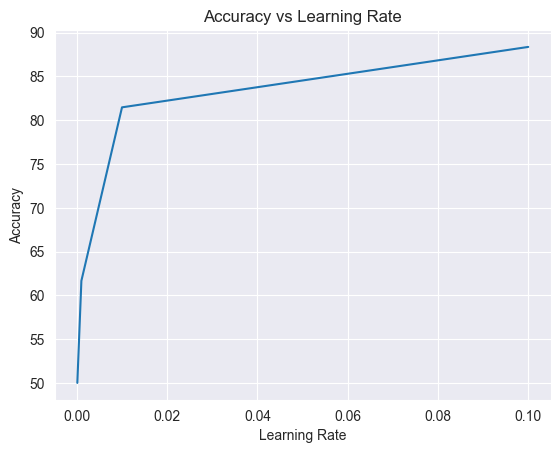

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
sns.lineplot(x=lr_list, y=acc_list)

# Add labels and title
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Learning Rate")

# Show the plot
plt.show()

##### II.3.b) Valor ótimo do LR

Notamos que o valor ótimo para a Learning Rate foi de cerca de 0.1, com crescimento exponencial ao aumentá-la. Valores acima deste são grandes demais e não levam à otimização do modelo.

##### II.3.c) Mostre a equação utilizada no gradiente descendente e qual é o papel do LR no ajuste dos parâmetros (weights) do modelo da rede neural.

No processo de otimização de uma função, a fórmula utilizada para a estimativa do próximo valor da função é dada por:

````
valor atualizado = valor anterior - learning rate*gradiente
`````

Portanto o papel da LR é definir qual é o *tamanho* do passo a ser utilizado no processo de atualização.

##### II.4 Melhores a forma de tokenizar, isto é, pré-processar o dataset de modo que a codificação seja indiferente das palavras serem escritas com maiúsculas ou minúsculas e sejam pouco influenciadas pelas pontuações.
##### II.4.a) Mostre os trechos modificados para este novo tokenizador, tanto na seção I - Vocabulário, como na seção II - Dataset.

Na seção I - Vocabulário:

````
from torchtext.data import get_tokenizer

for (label, line) in list(IMDB(split='train'))[:n_samples]:
    if (use_tokenizer):
      tokenizer = get_tokenizer('basic_english')
      # tokenize the sentence
      line = tokenizer(line)
    counter.update(line.split())

    # Número de amostras positivas e negativas
    if (label == 1):
      counter_lbl['neg'] += 1
    else:
      counter_lbl['pos'] += 1
    counter_lbl['total'] += 1

    # Comprimento médio do texto das reviews em palavras
    tokenizer = get_tokenizer('basic_english')

    # tokenize the sentence
    tokens = tokenizer(line)

    # count the number of words
    total_review_len += len(tokens)

````

Na Seção II - Dataset:
São apenas necessárias alterações no encoder da sentença, conforme abaixo.

````
def encode_sentence(sentence, vocab, use_tokenizer):
    if (use_tokenizer):
       sentence = tokenizer(sentence)
       return [vocab.get(word, 0) for word in sentence]
    else:
      return [vocab.get(word, 0) for word in sentence.split()] # 0 for OOV
````


##### II.4.b) Recalcule novamente os valores do exercício I.2.c - número de tokens unknown, e apresente uma tabela comparando os novos valores com os valores obtidos com o tokenizador original e justifique os resultados obtidos.

Sem o tokenizador:

566141

Com o tokenizador:

174226

Estes valores se justificam pelo fato que o tokenizador altera as palavras das sentenças, mantendo apenas radicais, de forma que menos palavras não serão encontradas na base do vocabulário.


##### II.4.c) Execute agora no notebook inteiro com o novo tokenizador e veja o novo valor da acurácia obtido com a melhoria do tokenizador.

Sem o tokenizador:

Test Accuracy: 73.45% (Para LR = 0.1)

Com o tokenizador

Test Accuracy: 88.47% (Para LR = 0.1)

O aumento da acurácia é justificado pelo fato que menos palavras de cada sentença não serão reconhecidas (OneHot encoding não terá tantos valores zerados)

##### Os dados obtidos estão resumidos na tabela abaixo.

In [16]:
from tabulate import tabulate

# Sample data
data = [
    ['Sem Tokenizador', 566141, '73.45%'],
    ['Com Tokenizador', 174226, '88.47%'],
]

# Headers
headers = ['Uso do Tokenizador', 'Tokens Unknown', 'Test Accuracy']

# Print the table
print(tabulate(data, headers=headers))

Uso do Tokenizador      Tokens Unknown  Test Accuracy
--------------------  ----------------  ---------------
Sem Tokenizador                 566141  73.45%
Com Tokenizador                 174226  88.47%


#### Seção III

##### Vamos estudar agora o Data Loader da seção III do notebook. Em primeiro lugar anote a acurácia do notebook com as melhorias de eficiência de rodar em GPU, com ajustes de LR e do tokenizador. Em seguida mude o parâmetro shuffle na construção do objeto train_loader para False e execute novamente o notebook por completo e meça novamente a acurácia.

In [17]:
from tabulate import tabulate

# Sample data
data = [
    ['Com Shuffle', '88.47%'],
    ['Sem Shuffle', '50.00%']
]

# Headers
headers = ['Shuffle dos dados de Treinamento', 'Test Accuracy']

# Print the table
print(tabulate(data, headers=headers))

Shuffle dos dados de Treinamento    Test Accuracy
----------------------------------  ---------------
Com Shuffle                         88.47%
Sem Shuffle                         50.00%


##### III.1.a) Explique as duas principais vantagens do uso de batch no treinamento de redes neurais.

O uso de lotes em treinamento é importante por causa do aumento da eficiência computacional e para aumentar a estabilidade do gradiente.
A eficiência computacional é aumentada pois com lotes maiores a paralelização do processamento em GPUs é mais bem aproveitada, enquanto que a estabilidade do gradiente é aumentada durante o treinamento pois em cada iteração, o gradiente é calculado com base na função de perda para o lote inteiro reduzindo a variabilidade do gradiente em comparação com o cálculo individual para cada exemplo.

##### III.1.b) Explique por que é importante fazer o embaralhamento das amostras do batch em cada nova época.

O embarelhamento das amostras de batch do treinamento é essencial para aumentar a generabilidade do modelo. As razões para tanto são:

* Redução do viés das amostras ordenadas do início ao fim do dataset.
* Estabilização do gradiente (redução da oscilação causada por amostras ordenadas).
* Melhoria da convergência, pois amostras agrupadas de uma classe dificultam o processo de aprendizado da rede neural.

Em geral o embaralhamento de amostras de treinamento é um processo usual para a redução da generalização e a obtenção de um modelo de melhores características.


##### III.1.c) Se você alterar o shuffle=False no instanciamento do objeto test_loader, por que o cálculo da acurácia não se altera?

A acurácia não se altera pois em tempo de inferência (ou seja, fase de teste) os pesos do modelo não são alterados mais. Portanto, a base de testes é usada apenas para verificar a capacidade de generalização do modelo.



##### III.2.a) Faça um laço no objeto train_loader e meça quantas iterações o Loader tem. Mostre o código para calcular essas iterações. Explique o valor encontrado.

Modificações no código de treinamento (função train_mdl()) acima:
````
  for epoch in range(num_epochs):
      start_time = time.time()  # Start time of the epoch
      model.train()

      loop_count = 0

      train_loader_iterations = 0    
      for inputs, labels in train_loader:
          train_loader_iterations += 1
````
Número de interações por época:
````
Epoch [1/5],               Loss: 0.3918,               Elapsed Time: 6.79 sec,               Loader Iterations: 196
Epoch [2/5],               Loss: 0.3028,               Elapsed Time: 0.56 sec,               Loader Iterations: 196
Epoch [3/5],               Loss: 0.1997,               Elapsed Time: 0.57 sec,               Loader Iterations: 196
Epoch [4/5],               Loss: 0.1883,               Elapsed Time: 0.57 sec,               Loader Iterations: 196
Epoch [5/5],               Loss: 0.3806,               Elapsed Time: 0.56 sec,               Loader Iterations: 196

````

##### III.2.b) Imprima o número de amostras do último batch do train_loader e justifique o valor encontrado? Ele pode ser menor que o batch_size?

````
Number of samples in last batch: 40
````
O valor encontrado é menor que o tamanho do batch size (nesse caso, 128) pois esta é a quantidade de amostras restantes nas base. Como temos 196 iterações, o total de amostras nos primeiros 195 ciclos totaliza 24.960. Portanto, o último batch tem um total de 25.000 (tamanho da base) - 24.960 = 40.

##### III.2.c) Calcule R, a relação do número de amostras positivas sobre o número de amostras no batch e no final encontre o valor médio de R, para ver se o data loader está entregando batches balanceados. Desta vez, em vez de fazer um laço explícito, utilize list comprehension para criar uma lista contendo a relação R de cada amostra no batch. No final, calcule a média dos elementos da lista para fornecer a resposta final.

Médias de R por época:
````
R avg: 0.4999 
R avg: 0.5004 
R avg: 0.5003 
R avg: 0.4999 
R avg: 0.5000
````

##### III.2.d) Mostre a estrutura de um dos batches. Cada batch foi criado no método __getitem__ do Dataset, linha 20. É formado por uma tupla com o primeiro elemento sendo a codificação one-hot do texto e o segundo elemento o label esperado, indicando positivo ou negativo. Mostre o shape (linhas e colunas) e o tipo de dado (float ou integer), tanto da entrada da rede como do label esperado. Desta vez selecione um elemento do batch do train_loader utilizando as funções next e iter: batch = next(iter(train_loader)).

In [18]:
my_loader = DataLoader(train_data, batch_size=1)
batch = next(iter(my_loader))

# Dado de entrada
entrada = batch[0].tolist()
dado_entrada = (batch[0])[0]

print("Dado de entrada:")
print(dado_entrada.size())
print(dado_entrada.dtype)
print()

# Label
print("Label:")
lbl = batch[1]
print(lbl.size())
print(lbl.dtype)

Dado de entrada:
torch.Size([20001])
torch.float32

Label:
torch.Size([1])
torch.int64


##### III.3.a) Verifique a influência do batch size na acurácia final do modelo. Experimente usar um batch size de 1 amostra apenas e outro com mais de 128 e comente sobre os resultados.

Notei que o cálculo de perda da linha criterion() gera um erro com batch size = 1, então usei batch size = 2 para este exercício.

In [19]:
# Acurácia com batch = 2
train_loader = DataLoader(train_data, batch_size=2, shuffle=train_shuffle)
model = OneHotMLP(vocab_size) # to reset weights
train_mdl(model, best_LR)
eval_mdl(model)
print()

# Acurácia com batch = 256
train_loader = DataLoader(train_data, batch_size=256, shuffle=train_shuffle)
model = OneHotMLP(vocab_size) # to reset weights
train_mdl(model, best_LR)
eval_mdl(model)
print()

Epoch [1/5],               Loss: 0.3425,               Elapsed Time: 40.08 sec,               Loader Iterations: 12500,               Spls lst batch: 2 ,               R avg: 0.5000 
Epoch [2/5],               Loss: 0.0033,               Elapsed Time: 44.47 sec,               Loader Iterations: 12500,               Spls lst batch: 2 ,               R avg: 0.5000 
Epoch [3/5],               Loss: 0.0014,               Elapsed Time: 49.71 sec,               Loader Iterations: 12500,               Spls lst batch: 2 ,               R avg: 0.5000 
Epoch [4/5],               Loss: 0.2785,               Elapsed Time: 96.74 sec,               Loader Iterations: 12500,               Spls lst batch: 2 ,               R avg: 0.5000 
Epoch [5/5],               Loss: 0.0000,               Elapsed Time: 83.67 sec,               Loader Iterations: 12500,               Spls lst batch: 2 ,               R avg: 0.5000 
Test Accuracy: 86.588%

Epoch [1/5],               Loss: 0.4868,               Elapse

Pudemos verificar que o batch size muito reduzido aumenta em muito a acurácia, mas em contrapartida aumenta muito a complexidade computacional. O ganho da acurácia pode ser explicado pela melhoria na generalização. Nesse caso os pesos do modelo são atualizados depois da análise de cada amostra de forma independente. O aumento do batch size de 128 para 256 não trouxe ganhos na acurácia.
Portanto, para datasets pequenos como o caso deste exercício, uma redução do tamanho do batch pode ser benéfico desde que o custo computacional não seja excessivo.

#### Seção IV

##### IV.1.a) Faça a predição do modelo utilizando um batch do train_loader: extraia um batch do train_loader, chame de (input, target), onde input é a entrada da rede e target é o label esperado. Como a rede está com seus parâmetros (weights) aleatórios, o logito de saída da rede será um valor aleatório, porém a chamada irá executar sem erros:

logit = model( input)

aplique a função sigmoidal ao logito para convertê-lo numa probabilidade de valor entre 0 e 1.


In [20]:
import numpy as np
new_loader = DataLoader(train_data, batch_size=128, shuffle=train_shuffle)
model = OneHotMLP(vocab_size).to(device) 

input, target = next(iter(new_loader))
logit = model(input)

# Define the sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

probability = sigmoid(logit[0])*100

# Cálculo da probabilidade para a primeira amostra
print(f'Probabilidade: {probability.item():.2f} %')


Probabilidade: 51.34 %


##### IV.1.b) Agora, treine a rede executando o notebook todo e verifique se a acurácia está alta. Agora repita o exercício anterior, porém agora, compare o valor da probabilidade encontrada com o target esperado e verifique se ele acertou. Você pode considerar que se a probabilidade for maior que 0.5, pode-se dar o label 1 e se for menor que 0.5, o label 0. Observe isso que é feito na linha 11 da seção VI - Avaliação.

In [21]:
import numpy as np
new_loader = DataLoader(train_data, batch_size=128, shuffle=train_shuffle)
model = OneHotMLP(vocab_size).to(device) 

input, target = next(iter(new_loader))
logit = model(input).cpu()

predicted = torch.round(torch.sigmoid(logit.squeeze()))

print("Predição = ", predicted[0].item())
print("Target Esperado = ", target[0].item())

Predição =  0.0
Target Esperado =  0


Se você der um print no modelo: print(model), você obterá:  
````
OneHotMLP(
  (fc1): Linear(in_features=20001, out_features=200, bias=True)  
  (fc2): Linear(in_features=200, out_features=1, bias=True)  
  (relu): ReLU()
)
````
Os pesos da primeira camada podem ser visualizados com model.fc1.weight e o elemento constante (bias) pode ser visualizado com model.fc1.bias  
Calcule o número de parâmetros do modelo, preenchendo a seguinte tabela (utilize shape para verificar a estrutura de cada parâmetro do modelo).

In [22]:
from tabulate import tabulate

model = OneHotMLP(vocab_size)

w_fc1 = model.fc1.weight.size()
b_fc1 = model.fc1.bias.size()
w_fc2 = model.fc2.weight.size()
b_fc2 = model.fc2.bias.size()

print("Model Parameters:")
print("FC1 weights dimensions: ", list(w_fc1))
print("FC2 weights dimensions: ", list (w_fc2))
print("FC1 bias dimensions: ", list(b_fc1))
print("FC2 bias dimensions: ", list (b_fc2))
print()

# Table data
data = [
    ['', 'weight', 'bias', 'weight', 'bias', ''],
    ['size', w_fc1[0]*w_fc1[1], b_fc1[0], w_fc2[0]*w_fc2[1], b_fc2[0], '']
]

# Headers
headers = ['layer', 'fc1', '', 'fc2', '', 'total']

# Print the table
print(tabulate(data, headers=headers))

Model Parameters:
FC1 weights dimensions:  [200, 20001]
FC2 weights dimensions:  [1, 200]
FC1 bias dimensions:  [200]
FC2 bias dimensions:  [1]

layer    fc1            fc2           total
-------  -------  ----  ------  ----  -------
         weight   bias  weight  bias
size     4000200  200   200     1


#### Seção V

##### V.1.a) Qual é o valor teórico da Loss quando o modelo não está treinado, mas apenas inicializado? Isto é, a probabilidade predita tanto para a classe 0 como para a classe 1, é sempre 0,5 ? Justifique. Atenção: na equação da Entropia Cruzada utilize o logaritmo natural.

Utilizando a equação da entropia cruzada, podemos obter o valor teórico da perda:

Loss = -1/n SumN (yi * ln(y^i) + (1-yi)ln(1-y^i))

com y^i = 0.5, temos: ln(y^i) = ln(1-y^i) = ln(0.5) = -0.69314

Loss = -1/n SumN(yi * (-0.69314) + (1-yi) * (-0.69314))
Loss = -1/n SumN(-0.69314yi - 0.69314 + 0.69314yi)

cancelando ambos termos em yi ->

Loss = -1/n SumN(-0.69314) e portanto Loss = 0.69314 para o modelo inicializado independente do número de amostras N.

No entanto, para um modelo não inicializado, o valor da perda depende do valor dos pesos da rede neural não inicializada, que pode variar e não ser o mesmo que o valor teórico.


##### V.1.b) Utilize as amostras do primeiro batch: (input,target) = next(iter(train_loader)) e calcule o valor da Loss utilizando a equação fornecida anteriormente utilizando o pytorch. Verifique se este valor confere com o valor teórico do exercício anterior.

In [23]:
new_loader = DataLoader(train_data, batch_size=128, shuffle=train_shuffle)
model = OneHotMLP(vocab_size).to(device) 

input, target = next(iter(new_loader))
logit = model(input)
prob = torch.sigmoid(logit)

# Calculo numérico da perda
loss = - torch.sum(torch.mul(target, torch.log(prob).t()) + torch.mul(1-target, torch.log(1-prob).t())) / prob.shape[0]
print(loss)


tensor(0.6941, device='cuda:0', grad_fn=<DivBackward0>)


Notamos que para um batch acima o valor da perda calculada não é a mesma da perda teórica, mas é muito próxima devido aos valores dos pesos não inicializados da rede neural.

##### V.1.c) O pytorch possui várias funções que facilitam o cálculo da Loss pela Entropia Cruzada. Utilize a classe nn.BCELoss (Binary Cross Entropy Loss). Você primeiro deve instanciar uma função da classe nn.BCELoss. Esta função instanciada recebe dois parâmetros (probs , targets) e retorna a Loss. Use a busca do Google para ver a documentação do BCELoss do pytorch. Calcule então a função de Loss da entropia cruzada, porém usando agora a função instanciada pelo BCELoss e confira se o resultado é exatamente o mesmo obtido no exercício anterior.

In [24]:
loss_fn = nn.BCELoss()

loss = loss_fn(prob.squeeze(), target.float())
print(loss)

tensor(0.6941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


Notamos que o valor foi o mesmo que o obtido acima.

##### V.1.d) Repita o mesmo exercício, porém agora usando a classe nn.BCEWithLogitsLoss, que é a opção utilizada no notebook. O resultado da Loss deve igualar aos resultados anteriores.

In [25]:
loss_fn = nn.BCEWithLogitsLoss()

loss = loss_fn(logit.squeeze(), target.float())
print(loss)

tensor(0.6941, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


Novamente chegamos ao mesmo valor calculado.

##### V.2.a) Modifique a célula do laço de treinamento de modo que a primeira Loss a ser impressa seja a Loss com o modelo inicializado (isto é, sem nenhum treinamento), fornecendo a Loss esperada conforme os exercícios feitos anteriormente. Observe que desta forma, fica fácil verificar se o seu modelo está correto e a Loss está sendo calculada corretamente. Atenção: Mantenha esse código da impressão do valor da Loss inicial, antes do treinamento, nesta célula, pois ela é sempre útil para verificar se não tem nada errado, antes de começar o treinamento.


In [26]:
# Medição da perda
def train_first_loss(model, lr):

  model = model.to(device)
  # Define loss and optimizer
  criterion = nn.BCEWithLogitsLoss()

  optimizer = optim.SGD(model.parameters(), lr)

  # Training loop
  num_epochs = 5
  # First loss calculation
  is_first_loss = True

  for epoch in range(num_epochs):
      start_time = time.time()
      model.train()

      for inputs, labels in train_loader:

          if not preload_to_gpu:
            inputs = inputs.to(device)
            labels = labels.to(device)

          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), labels.float())

          if is_first_loss:
            print(f'Loss before training: {loss.item():.4f}')
            is_first_loss = False
            print()

          # Backward and optimize
          backward_start = time.time()
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print(f'Epoch [{epoch+1}/{num_epochs}], \
              Loss: {loss.item():.4f}')
  print()
  
model = OneHotMLP(vocab_size)       
train_first_loss(model, best_LR)

Loss before training: 0.6937

Epoch [1/5],               Loss: 0.4589
Epoch [2/5],               Loss: 0.3735
Epoch [3/5],               Loss: 0.3310
Epoch [4/5],               Loss: 0.3072
Epoch [5/5],               Loss: 0.3820



Notamos que o primeiro valor calculado da perda se manteve o mesmo.

##### V.2.b) Execute a célula de treinamento por uma segunda vez e observe que a Loss continua diminuindo e o modelo está continuando a ser treinado. O que é necessário fazer para que o treinamento comece novamente do modelo aleatório? Qual(is) célula(s) é(são) preciso executar antes de executar o laço de treinamento novamente?

Para que o treinamento inicie novamente, os pesos devem ser resetados a seus valores iniciais.
Uma maneira de fazer isso é criando uma função que resete os parãmetros de cada camada, por exemplo:

In [27]:
def reset_weights(model):
  for module in model.modules():
    if isinstance(module, nn.Linear):
      module.reset_parameters()

E adicionar ao loop de treinamento acima.

In [28]:
# Medição da perda
def train_first_loss_reset(model, lr):

  model = model.to(device)
  reset_weights(model)
  # Define loss and optimizer
  criterion = nn.BCEWithLogitsLoss()

  optimizer = optim.SGD(model.parameters(), lr)

  # Training loop
  num_epochs = 5
  # First loss calculation
  is_first_loss = True

  for epoch in range(num_epochs):
      start_time = time.time()
      model.train()

      for inputs, labels in train_loader:

          if not preload_to_gpu:
            inputs = inputs.to(device)
            labels = labels.to(device)

          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), labels.float())

          if is_first_loss:
            print(f'Loss before training: {loss.item():.4f}')
            is_first_loss = False
            print()

          # Backward and optimize
          backward_start = time.time()
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print(f'Epoch [{epoch+1}/{num_epochs}], \
              Loss: {loss.item():.4f}')
  print()

Sem o reset de parâmetros:

In [29]:
model = OneHotMLP(vocab_size)       
train_first_loss(model, best_LR)
train_first_loss(model, best_LR)

Loss before training: 0.6940

Epoch [1/5],               Loss: 0.5194
Epoch [2/5],               Loss: 0.3760
Epoch [3/5],               Loss: 0.2819
Epoch [4/5],               Loss: 0.4003
Epoch [5/5],               Loss: 0.2831

Loss before training: 0.2748

Epoch [1/5],               Loss: 0.2053
Epoch [2/5],               Loss: 0.2446
Epoch [3/5],               Loss: 0.3596
Epoch [4/5],               Loss: 0.2303
Epoch [5/5],               Loss: 0.2986



Com reset de parâmetros:

In [30]:
model = OneHotMLP(vocab_size)       
train_first_loss_reset(model, best_LR)
train_first_loss_reset(model, best_LR)

Loss before training: 0.6958

Epoch [1/5],               Loss: 0.4968
Epoch [2/5],               Loss: 0.3918
Epoch [3/5],               Loss: 0.2831
Epoch [4/5],               Loss: 0.3358
Epoch [5/5],               Loss: 0.2670

Loss before training: 0.6927

Epoch [1/5],               Loss: 0.4967
Epoch [2/5],               Loss: 0.3932
Epoch [3/5],               Loss: 0.2716
Epoch [4/5],               Loss: 0.2638
Epoch [5/5],               Loss: 0.3580



##### V.3.a) Repita o exercício V.1.a) porém agora utilizando a equação acima.

M - número de amostras  
N - número de classes  

loss = - 1/(M*N) sumM (sumN (yij*log(y^ij)))

Podemos supor 2 classes (positiva e negativa, e portanto y^ij = 50%)

daí log(y^ij) = log(0.5) = -0.69314.

Com duas classes:

sumN(yij*log(y^ij)) = 2*(yij*(-0.69314)) = -1.38628*yij

loss = -1/(M*N)* sumM(-1.38628*yij)

Se temos duas classes, podemos assumir que metade são da classe 0 e metade da classe 1, e portanto 

sumM(yij) = M/2

daí a perda seria dada por 

loss = -1/(M*2)*(M/2)*-1.38628 =  1.38628/2 = 0.69314.


##### V.3.b) Modifique a camada de saída da rede para 2 logitos e utilize a função Softmax para converter os logitos em probabilidades. Repita o exercício V.1.b)

In [31]:
class OneHotMLP_2logits(nn.Module):
    def __init__(self, vocab_size):
        super(OneHotMLP_2logits, self).__init__()
        self.fc1 = nn.Linear(vocab_size+1, 200)
        self.fc2 = nn.Linear(200, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        o = self.fc1(x.float())
        o = self.relu(o)
        o = self.fc2(o)
        return self.softmax(o)

In [32]:
import torch.nn.functional as F

new_loader = DataLoader(train_data, batch_size=128, shuffle=train_shuffle)
model = OneHotMLP_2logits(vocab_size).to(device) 

input, target = next(iter(new_loader))
probs_2logits = model(input)

# Calculo numérico da perda
log_probs = F.log_softmax(probs_2logits, dim=1)
log_probs_correct_class = torch.gather(log_probs, 1, target.unsqueeze(1)).squeeze(1)
loss = -log_probs_correct_class.mean()
print(loss)

tensor(0.6941, device='cuda:0', grad_fn=<NegBackward0>)


##### V.3.c) Utilize agora a função nn.CrossEntropyLoss para calcular a Loss e verifique se os resultados são os mesmos que anteriormente.

In [33]:
loss_fn = nn.CrossEntropyLoss()

loss = loss_fn(probs_2logits.squeeze(), target)
print(loss)

tensor(0.6941, device='cuda:0', grad_fn=<NllLossBackward0>)


Notamos que o valor foi o mesmo que o obtido acima.


##### V.3.d) Modifique as seções V e VI para que o notebook funcione com a saída da rede com 2 logitos. Há necessidade de alterar o laço de treinamento e o laço de cálculo da acurácia.


In [34]:
# Treinamento e inferência multi-classe

def train_two_logits(model, lr):

  model = model.to(device)
  reset_weights(model)
  # Define loss and optimizer
  criterion = nn.CrossEntropyLoss()

  optimizer = optim.SGD(model.parameters(), lr)

  # Training loop
  num_epochs = 5

  for epoch in range(num_epochs):

      model.train()

      for inputs, labels in train_loader:

          if not preload_to_gpu:
            inputs = inputs.to(device)
            labels = labels.to(device)

          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), labels)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print(f'Epoch [{epoch+1}/{num_epochs}], \
              Loss: {loss.item():.4f}')
  print()

def eval_two_logits(model):
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100* correct/total
        print(f'Test Accuracy: {acc}%')
    return acc


model = OneHotMLP_2logits(vocab_size)       
train_two_logits(model, best_LR)
eval_two_logits(model)

Epoch [1/5],               Loss: 0.5808
Epoch [2/5],               Loss: 0.4986
Epoch [3/5],               Loss: 0.4950
Epoch [4/5],               Loss: 0.4730
Epoch [5/5],               Loss: 0.4536

Test Accuracy: 86.684%


86.684

#### Seção VI

##### VI.1.a) Calcule o número de amostras que está sendo considerado na seção de avaliação.


In [35]:
print(len(test_data))

25000


##### VI.1.b) Explique o que faz os comandos model.eval()e with torch.no_grad().

O comando model.eval() informa para o Pytorch que estamos em modo de inferência, o que faz com que algumas camadas dos modelos (como camadas de dropout) sejam desabilitadas.

O loop **with torch.no_grad()** informa o Pytorch para não calcular gradientes relacionados a um tensor. Assim, loops onde o gradiente precisa ser preservado utilizam essa configuração.


##### VI.1.c) Existe uma forma mais simples de calcular a classe predita na linha 11, sem a necessidade de usar a função torch.sigmoid?

Torch.sigmoid() é uma função de ativação, para transformar uma entrada numérica em um número entre zero e um. Uma maneira muito simples de fazer a mesma coisa é dividir a entrada pelo valor máximo da entrada observada, além de, claro, utilizar outras funções de ativação alternativas (ReLU, etc).

##### VI.2.a) Utilizando a resposta do exercício V.1.a, que é a Loss teórica de um modelo aleatório de 2 classes, qual é o valor da perplexidade?

In [36]:
torch.exp(torch.tensor(-0.69314))

tensor(0.5000)

A perplexidade neste caso nos retorna a probabilidade de distribuição das classes de 50%.

##### VI.2.b) E se o modelo agora fosse para classificar a amostra em N classes, qual seria o valor da perplexidade para o caso aleatório?

Para N classes, a perplexidade seria dada por 1/N.

##### VI.2.c) Qual é o valor da perplexidade quando o modelo acerta todas as classes com 100% de probabilidade?

Quando um modelo acerta 100% das previsões, a perplexidade é 1.


##### VI.3.a) Modifique o código da seção VI - Avaliação, para que além de calcular a acurácia, calcule também a perplexidade. lembrar que PPL = torch.exp(CE). Assim, será necessário calcular a entropia cruzada, como feito no laço de treinamento.

In [37]:
def eval_with_perplexity(model):
    model.eval()

    criterion = nn.CrossEntropyLoss()
    #total_loss = 0
    #total_labels = 0
    perplexity = 0

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            perplexity = torch.exp(loss)
                        
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100* correct/total
        print(f'Test Accuracy: {acc}% \
                Test Perplexity: {perplexity}')
    return acc

eval_with_perplexity(model)

Test Accuracy: 86.684%                 Test Perplexity: 1.5966792106628418


86.684

##### VI.4.a) Modifique o laço de treinamento para incorporar também o cálculo da avaliação ao final de cada época. Aproveite para reportar também a perplexidade, tanto do treinamento como da avaliação (observe que será mais fácil de interpretar). Essa é a forma usual de se fazer o treinamento, monitorando se o modelo não entra em overfitting.

In [38]:

def train_and_eval(model, lr, epochs):

  model = model.to(device)
  reset_weights(model)
  # Define loss and optimizer
  criterion = nn.CrossEntropyLoss()

  optimizer = optim.SGD(model.parameters(), lr)

  perplexity = 0
  for epoch in range(epochs):

      model.train()

      for inputs, labels in train_loader:

          if not preload_to_gpu:
            inputs = inputs.to(device)
            labels = labels.to(device)

          # Forward pass
          outputs = model(inputs)
          loss = criterion(outputs.squeeze(), labels)
          perplexity = torch.exp(loss)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      eval_with_perplexity(model)
      model.train()

      print(f'Epoch [{epoch+1}/{epochs}], \
              Loss: {loss.item():.4f}, \
              Train Perplexity: {perplexity}')
  print()

model = OneHotMLP_2logits(vocab_size)       
train_and_eval(model, best_LR, 5)

Test Accuracy: 80.052%                 Test Perplexity: 1.8723005056381226
Epoch [1/5],               Loss: 0.5857,               Train Perplexity: 1.796219825744629
Test Accuracy: 82.9%                 Test Perplexity: 1.6462186574935913
Epoch [2/5],               Loss: 0.4948,               Train Perplexity: 1.640202522277832
Test Accuracy: 85.208%                 Test Perplexity: 1.673960566520691
Epoch [3/5],               Loss: 0.4974,               Train Perplexity: 1.6444705724716187
Test Accuracy: 86.156%                 Test Perplexity: 1.6198530197143555
Epoch [4/5],               Loss: 0.4556,               Train Perplexity: 1.5771275758743286
Test Accuracy: 86.76%                 Test Perplexity: 1.609909176826477
Epoch [5/5],               Loss: 0.4503,               Train Perplexity: 1.568806529045105



##### Por fim, como o dataset tem muitas amostras, ele é demorado de entrar em overfitting. Para ficar mais evidente, diminua novamente o número de amostras do dataset de treino de 25 mil para 1 mil amostras e aumente o número de épocas para ilustrar o caso do overfitting, em que a perplexidade de treinamento continua caindo, porém a perplexidade no conjunto de teste começa a aumentar. 

In [41]:
batch_size = 128

train_data_short = IMDBDataset('train', vocab, samples = 1000)
test_data_short = IMDBDataset('test', vocab, samples = 1000)

train_loader = DataLoader(train_data_short, batch_size=batch_size, shuffle=train_shuffle)
test_loader = DataLoader(test_data_short, batch_size=batch_size, shuffle=False)

model = OneHotMLP_2logits(vocab_size)       
train_and_eval(model, best_LR, 100)

KeyboardInterrupt: 